In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers

# Data Processing

In [2]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

['Validation', 'Test', 'Train']


In [2]:
batch_size = 1024         
shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range = 0.2,
                                   zoom_range = 0.2, horizontal_flip = True,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   fill_mode='nearest', preprocessing_function=add_noise)
train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 181665 images belonging to 2 classes.
Found 17765 images belonging to 2 classes.


In [4]:
print(train.class_indices)
print(train.classes)

{'Female': 0, 'Male': 1}
[0 0 0 ... 1 1 1]


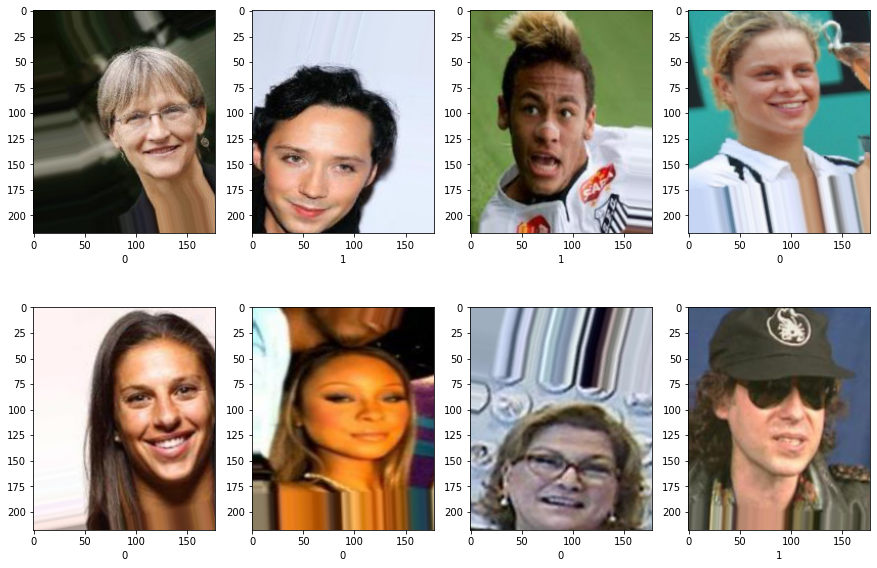

In [7]:
# Show photos of men's dataset
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Build Model Inception V3


![](https://ascelibrary.org/cms/asset/12a9919d-5ff3-4801-b0a7-71569e296fce/figure5.jpg)

In [3]:
input_shape = (218, 178, 3)

pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights="imagenet")

for i,layer in enumerate(pre_trained_model.layers):
    print(i,layer.name)
print("\nInput:", pre_trained_model.input)
print("Output:", pre_trained_model.output)

0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [10]:
# Visualation Inception V3 architecture
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Fine Turning Parameters by Grid Search

In [21]:
# Set data for fine tuning
X_f = []
y_f = []
for i in range(20):
    img, label = next(train)
    X_f.append(img)
    y_f.append(label)
X_fine_tuning = np.concatenate(X_f)
y_fine_tuning = np.concatenate(y_f)
print(len(X_fine_tuning))

960


In [ ]:
def define_model(learning_rate=0.0001, optimizer='Adam'):
    pre_trained_model = InceptionV3(input_shape=(218, 178, 3),include_top=False, weights="imagenet")
    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
    x = GlobalMaxPooling2D()(last_output)
    #x = layers.Flatten()(last_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

# Set parameters default
epochs=20
batch_size=32

model = KerasClassifier(build_fn=define_model, epochs=epochs,
                        batch_size=batch_size, verbose=1)

# List Parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam', 'Ftrl']
learning_rate = [0.001, 0.01, 0.1]

param_grid = dict(optimizer=optimizer, learning_rate=learning_rate)

checkpoint_f = ModelCheckpoint('model_fine_tuning.h5', verbose = 0, mode='auto', monitor = 'val_accuracy',
                               save_best_only = True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3) #Máy mạnh thì n_jobs = -1
grid_result = grid.fit(X_fine_tuning, y_fine_tuning, callbacks=[checkpoint_f], validation_split=0.2)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best: 0.881250 using {'learning_rate': 0.001, 'optimizer': 'Adagrad'}

# Train Model

In [3]:
input_shape = (218, 178, 3)
pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights="imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# x = layers.Flatten()(last_output)
x = Dense(512, activation='relu')(x)
# Dropout layer to reduce overfitting
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

#threshold = 0.5
# METRICS = [
#   TruePositives(name='tp', thresholds = threshold),
#   FalsePositives(name='fp', thresholds = threshold),
#   TrueNegatives(name='tn', thresholds = threshold),
#   FalseNegatives(name='fn', thresholds = threshold),
#   BinaryAccuracy(name='accuracy', threshold = threshold),
#   Precision(name='precision', thresholds = threshold),
#   Recall(name='recall', thresholds = threshold),
#   AUC(name='auc')
# ]

model.compile(keras.optimizers.Adagrad(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Best: 0.881250 using {'learning_rate': 0.001, 'optimizer': 'Adagrad'}

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 108, 88, 32)  864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 108, 88, 32)  96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 108, 88, 32)  0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [4]:
# Train Model with fine tuning parameters

checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train,
    epochs=20,
    validation_data=val,
    verbose=1,
    callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-17 19:12:16.771028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-17 19:12:21.164092: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 36/177 [=====>........................] - ETA: 1:06 - loss: 0.7564 - accuracy: 0.5608

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


177/177 [==============================] - 97s 492ms/step - loss: 0.5952 - accuracy: 0.6831 - val_loss: 0.3932 - val_accuracy: 0.8346

Epoch 00001: val_accuracy improved from -inf to 0.83456, saving model to training_save.h5
Epoch 2/20
177/177 [==============================] - 86s 486ms/step - loss: 0.4384 - accuracy: 0.7938 - val_loss: 0.3084 - val_accuracy: 0.8842

Epoch 00002: val_accuracy improved from 0.83456 to 0.88419, saving model to training_save.h5
Epoch 3/20
177/177 [==============================] - 87s 490ms/step - loss: 0.3875 - accuracy: 0.8310 - val_loss: 0.2898 - val_accuracy: 0.8934

Epoch 00003: val_accuracy improved from 0.88419 to 0.89338, saving model to training_save.h5
Epoch 4/20
177/177 [==============================] - 81s 459ms/step - loss: 0.3722 - accuracy: 0.8404 - val_loss: 0.2669 - val_accuracy: 0.9026

Epoch 00004: val_accuracy improved from 0.89338 to 0.90257, saving model to training_save.h5
Epoch 5/20
177/177 [==============================] - 82s 

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


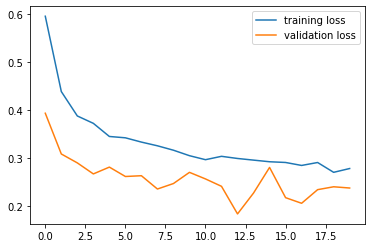

In [5]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()
plt.show();

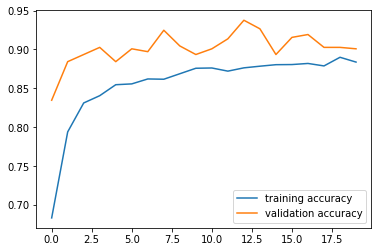

In [6]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


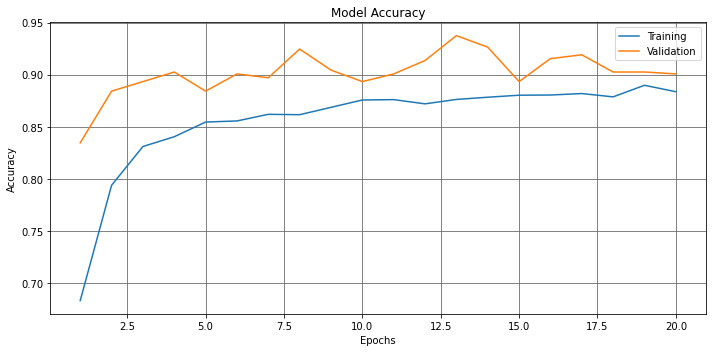

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


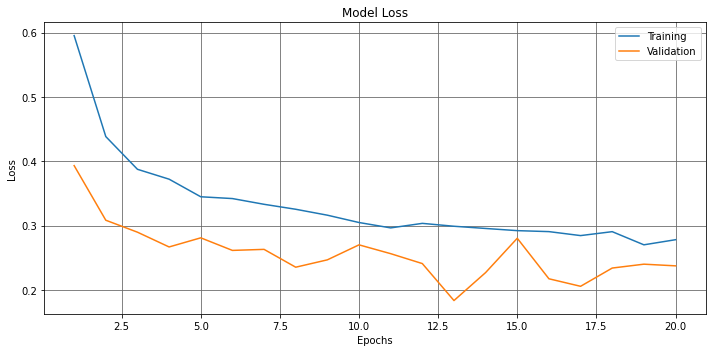

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
np.save('inception_history_20e.npy',history.history)

# Evaluation on test set

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=(218,178), batch_size=32,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 16779 images belonging to 2 classes.


In [9]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

16779


              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      8320
         1.0       0.92      0.91      0.92      8459

    accuracy                           0.92     16779
   macro avg       0.92      0.92      0.92     16779
weighted avg       0.92      0.92      0.92     16779

Confusion matrix, without normalization
[[7682  638]
 [ 728 7731]]


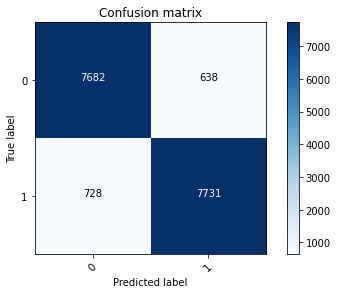

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.918589
Precision: 0.918601
Recall: 0.918628
F1 score: 0.918588
ROC AUC: 0.918628


In [ ]:
# Saving model
model.save('inception_model_92_accuracy.h5')
print('Done! Model Saved!')

In [ ]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/model_inception_89_acc.h5')